In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pulp import *
import math
from ortools.linear_solver import pywraplp
sns.set()

In [ ]:
production = pd.read_csv("production.csv")
purchasing = pd.read_csv("purchasing.csv")
bom = pd.read_csv('bom.csv')
stock = pd.read_csv("stock.csv")
components = pd.read_csv('components.csv')
articles = pd.read_csv("articles.csv")

purchasing['date'] = pd.to_datetime(purchasing['date'])
production['date']  = pd.to_datetime(production['date'])
stock['date'] = pd.to_datetime(stock['date'])

#preprocess stock and purchasing to work with follow ups
def processFollowUp(components, stock, purchasing, bom):
    #replace new component numbers for old component numbers in stock, purchasing, bom
    replaceDict = components[~np.isnan(components['follow_up_component'])][['component_number','follow_up_component']].astype('int').set_index('follow_up_component')['component_number'].to_dict()
    purchasing['component_number'] = purchasing['component_number'].replace(replaceDict)
    stock['component_number'] = stock['component_number'].replace(replaceDict)
    bom['component_number'] = bom['component_number'].replace(replaceDict)
    return stock, purchasing, bom

stock, purchasing, bom = processFollowUp(components, stock, purchasing, bom)


allComponents = set(bom['component_number']) | set(purchasing['component_number']) | set(stock['component_number'])

productionDays = list(production['date'].sort_values(ascending=True).unique())
purchasingDays = list(purchasing['date'].unique())
allDays = sorted(productionDays + purchasingDays)
allDays = list(dict.fromkeys(allDays))
day0 = allDays[0] 

#drop duplicates in bom for now, later allow for bom changes
bom = bom.drop_duplicates(subset=['article_number','component_number'])

In [ ]:
print(f"Total window for which production schedule is required: {production['date'].min()} - {production['date'].max()}")

Total window for which production schedule is required: 2022-02-16 00:00:00 - 2022-08-15 00:00:00


In [ ]:
#general cnfiguration
class Config():
    DAY_PRODUCTION_CAPACITY = 1184
    X_CAT = 'Integer'
    BATCH_SIZE = 16
    DAY_BATCH_PRODUCTION_CAPACITY = (DAY_PRODUCTION_CAPACITY/BATCH_SIZE)

### Pre processing

##### Add beginning inventory as purchase on day 0, to make simpler

In [ ]:
def processNegativePurchasing(stock, purchasing):
    purchasingProcessed = purchasing.copy()
    purchasingProcessed = pd.concat([stock, purchasing])
    purchasingProcessed = purchasingProcessed.groupby(by=["component_number", "date"]).sum().reset_index().sort_values(by=['date','component_number'])

    for componentNumber in tqdm(purchasing['component_number'].unique()):
        stockOverTime = purchasingProcessed.loc[purchasingProcessed['component_number'] == componentNumber, "quantity"].cumsum()
        stockOverTimeMonotonicallyIncreasing = pd.Series(index = stockOverTime.index, data = np.minimum.accumulate(stockOverTime[::-1]))
        componentProcessedPurchasing = stockOverTimeMonotonicallyIncreasing - stockOverTimeMonotonicallyIncreasing.shift(1, fill_value=0)
        purchasingProcessed.loc[purchasingProcessed['component_number'] == componentNumber, 'quantity'] = componentProcessedPurchasing.values
    return purchasingProcessed

In [ ]:
purchasingProcessed = processNegativePurchasing(stock, purchasing)

100%|██████████| 1335/1335 [00:02<00:00, 517.36it/s]


In [ ]:
def convertToBatchSize(bom, articles, batchSize):
    # bom quantities * batchSize
    # articles revenue * 16
    bomProcessed = bom.copy()
    articlesProcessed = articles.copy()
    bomProcessed['quantity'] = bomProcessed['quantity'] * batchSize
    articlesProcessed['revenue'] = articlesProcessed['revenue'] * batchSize
    return bomProcessed, articlesProcessed

In [ ]:
bomBatch, articlesBatch = convertToBatchSize(bom, articles, Config.BATCH_SIZE)

### Some classes & methods

In [ ]:
class Inventory(object):
    def __init__(self, purchasing: pd.DataFrame):
        self.purchasing = purchasing

    def purchasingForDay(self, date, componentNumber = None):
        date = self.checkTimestamp(date)

        if componentNumber is None:
            #returns pd.Series with component_number as index & quantity
            return self.purchasing[self.purchasing['date'] == date].set_index('component_number')['quantity'].reindex(allComponents, fill_value=0)
        else:
            #returns int with quantity
            return self.purchasing[(self.purchasing['date'] == date) & (self.purchasing['component_number'] == componentNumber)]['quantity'].sum()

    def purchasingForPeriod(self, beginDate, endDate, componentNumber = None, inclusive=True):

        beginDate, endDate = self.checkTimestamp(beginDate), self.checkTimestamp(endDate)

        if componentNumber is None:
            #returns pd.Series with component_number as index & quantity
            res = self.purchasing[self.purchasing['date'].between(beginDate, endDate, inclusive = inclusive)].groupby(by = 'component_number')['quantity'].sum().reindex(allComponents, fill_value=0)
            res[res<0] = 0
            return res 
            
        else:
            #returns int with quantity
            return self.purchasing[(self.purchasing['date'].between(beginDate, endDate, inclusive = inclusive)) & (self.purchasing['component_number'] == componentNumber)]['quantity'].sum()

    def checkTimestamp(self, date):
        if type(date) is str:
            return pd.Timestamp(date)
        else:
            return date

    def add(self, begginingInv: pd.Series, date):
        #add component inventory to first day (for residuals of previous period)
        if begginingInv is not None:
            begginingInvDf = begginingInv.reset_index()
            begginingInvDf['date'] = date
            self.purchasing = pd.concat([self.purchasing, begginingInvDf])
        return self




In [ ]:
test = Inventory(purchasingProcessed)

In [ ]:
remainingInventory = pd.Series(index = pd.Index(data=[0,1,2,3,4], name="component_number"), data=[2,3,4,3,2], name='quantity')

In [ ]:
test = test.addBeginningInv(remainingInventory)
test.purchasing

,component_number,date,quantity
0,0,2022-02-16,2297
34,1,2022-02-16,1998
126,3,2022-02-16,4074
132,4,2022-02-16,4842
138,5,2022-02-16,406
...,...,...,...
0,0,2022-02-16,2
1,1,2022-02-16,3
2,2,2022-02-16,4
3,3,2022-02-16,3


In [ ]:
def createPeriods(beginDate, endDate, nPeriods, inclusive=False):
    beginDate = pd.Timestamp(beginDate)
    endDate = pd.Timestamp(endDate)
    length = (endDate - beginDate).days
    lengthPerPeriod = int(length/nPeriods)
    res = []
    for i in range(nPeriods-1):
        addDay = (not inclusive) and (i is not 0)
        periodBegin =  beginDate + pd.Timedelta(days= i * lengthPerPeriod + addDay)
        periodEnd = beginDate + pd.Timedelta(days= (i+1) * lengthPerPeriod)
        res.append((periodBegin, periodEnd))
    
    res.append((res[-1][-1] + pd.Timedelta(days=int(not inclusive)), endDate))
    return res

In [ ]:
def nBusDays(periodBegin: pd.Timestamp, periodEnd: pd.Timestamp):
    periodBegin = periodBegin.to_pydatetime().date()
    periodEnd= periodEnd.to_pydatetime().date()
    return np.busday_count(periodBegin, periodEnd)

In [ ]:
def getBusDaysInPeriod(periodBegin: pd.Timestamp, periodEnd: pd.Timestamp):
    return list(pd.bdate_range(periodBegin, periodEnd))

In [ ]:
def getComponentsRequired(componentNumber, bom):
    required = bom[(bom['component_number'] == componentNumber)]
    if len(required) == 0:
        return 0
    return required.set_index("article_number")['quantity']

In [ ]:
def createProductionDf(x, daysInPeriod, articles): #articles = articlesBatch
    productionDict = {i:_.value() for i,_ in x.items()}
    productionDf = pd.DataFrame( productionDict.values(), index = productionDict.keys(), columns=['quantity_batch'])
    productionDf = productionDf.reset_index()
    productionDf.columns = ['article_number', 'day_nr', 'quantity_batch']
    productionDf['day'] = productionDf['day_nr'].apply(lambda el: daysInPeriod[el-1])
    productionDf = productionDf[['day','day_nr','article_number', 'quantity_batch']].sort_values(by=['day_nr','article_number'])
    productionDf['quantity'] = productionDf['quantity_batch'] * Config.BATCH_SIZE
    revenue = articles.set_index('article_number')['revenue'].to_dict()
    productionDf['article_revenue'] = productionDf['article_number'].apply(lambda el: revenue[el])
    productionDf['revenue_total'] = productionDf['article_revenue'] * productionDf['quantity_batch'] 
    return productionDf[productionDf['quantity'] > 0]

In [ ]:
def getRemainingComponents(productionDf:pd.DataFrame, totalPeriodInventory :pd.Series, bom):
    #take a productionDf and 
    #productionDf dataframe with columns article_number, quantity_tot
    #totalPeriodInventory  series with index component number values quantity
    #productionDfGrouped = productionDf.groupby(by='article_number').sum()['quantity_batch']
    componentUsage = pd.merge(left=productionDf, right=bom, left_on='article_number', right_on='article_number', how ='left')
    componentUsage['quantity'] = componentUsage['quantity_batch'] * componentUsage['quantity_y']
    componentUsage = componentUsage.groupby(by='component_number').sum()['quantity']
    remainingInventory = totalPeriodInventory.subtract(componentUsage, fill_value=0) 
    print("remaininginv", remainingInventory)
    #maybe only q>0
    return remainingInventory


In [ ]:
def checkWhichArticlesCanBeMade(purchasing, batch):
    purchasing = purchasing.groupby(by=['component_number']).sum()['quantity']
    for article in articles['article_number']:
        bomBatch = bom[bom['article_number'] == article].set_index('component_number')['quantity']
        diff = (purchasing.subtract(bomBatch, fill_value=0))
        print(article, ":\t", (diff>=0).all(), '\tMissing', list(diff[diff<0].index))

### Multi period formulation

P: production capacity per day \
$r_i$: revenue article i \
$q_{ij}$: Amount of component j needed for article i \
$x_{it}$: Quantity produced of article i on day t \
$d_{jt}$: Purchasing of component j arriving at the beggining of day t \
$T$ total duration of the period 


Objective: \
$Maximize$ $ \sum_{t=1}^T \sum_{i=1}^n x_{it}r_{i}$ \
st.  

$\sum_{t'=1}^{t}d_{jt'} - \sum_{t'=1}^{t} \sum_{i=1}^nx_{it'}q_{ij} >= 0 \hspace{20pt} t=1,...,T \hspace{10pt} j =1,...,m$ 

$\sum_{i=1}^n x_{it} <= P \hspace{86pt} t=1,...,T $

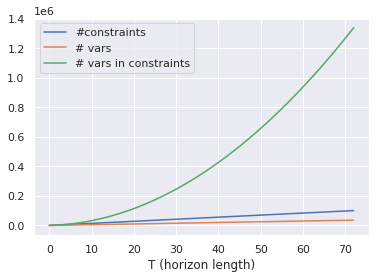

In [ ]:
def plotModelSize(T, n, m):
    nConstraints = [ t*m + t for t in range(T)]
    nVars = [ t*n for t in range(T)]
    nVarsInConstraints = [t*(t+1)/2 + t*(t+1)/2 * n + t * n for t in range(T)]
    sns.lineplot(x= np.arange(0,T), y=  nConstraints, label="#constraints")
    sns.lineplot(x= np.arange(0,T), y=  nVars, label="# vars")
    sns.lineplot(x= np.arange(0,T), y=  nVarsInConstraints, label="# vars in constraints")
    plt.legend()
    plt.xlabel("T (horizon length)")
plotModelSize(T=len(productionDays), n = len(articles['article_number'].unique()), m=len(components['component_number'].unique()))

In [ ]:
def multiPeriodILP(daysInPeriod, articles, inv: Inventory, bom):
    model = LpProblem(name='Production', sense=LpMaximize)
    T = len(daysInPeriod)
    x = {(i, t): LpVariable(name=f"x_p_{i},d_{t}", lowBound=0, upBound=Config.DAY_BATCH_PRODUCTION_CAPACITY, cat=Config.X_CAT) for i in articles['article_number'] for t in range(1,T+1)}
    print(f"Multi period ILP for period {daysInPeriod[0]} to {daysInPeriod[-1]}")
    print(f"This entails {T} days: {daysInPeriod}")
    #print(f"Created variables: {x}")
    revenue = articles.set_index('article_number')['revenue'].to_dict()
    #print(revenue)
    model += lpSum(x[(i,t)] * revenue[i] for i in articles['article_number'] for t in range(1,T+1))

    #Inventory constraints
    for t, day in enumerate(daysInPeriod,1):
        #purchasingDay = inv.purchasingForDay(day)

        purchasingUpToDay = inv.purchasingForPeriod(daysInPeriod[0], day)

        for j in allComponents:
            print("\r", end=f"{t},{j}")
            articlesComponentUsage = getComponentsRequired(j, bom)
            model += (purchasingUpToDay[j] - lpSum([x[(i,tt)] * articlesComponentUsage[i] for i in articlesComponentUsage.index for tt in range(1,t+1) ])) >= 0, f"InvConstraint_day_{t-1}_component_{j}"

        #Production capacity constraints
        model += lpSum([x[(i,t)] for i in articles['article_number']]) <= Config.DAY_BATCH_PRODUCTION_CAPACITY

    return model, x

In [ ]:
periodBegin = pd.Timestamp('2022-02-16')
periodEnd = pd.Timestamp('2022-03-01') 
daysInPeriod = getBusDaysInPeriod(periodBegin, periodEnd)
inv = Inventory(purchasingProcessed)
model, x = multiPeriodILP(daysInPeriod=daysInPeriod, articles = articlesBatch, inv = inv, bom = bomBatch)

Multi period ILP for period 2022-02-16 00:00:00 to 2022-03-01 00:00:00
This entails 10 days: [Timestamp('2022-02-16 00:00:00', freq='B'), Timestamp('2022-02-17 00:00:00', freq='B'), Timestamp('2022-02-18 00:00:00', freq='B'), Timestamp('2022-02-21 00:00:00', freq='B'), Timestamp('2022-02-22 00:00:00', freq='B'), Timestamp('2022-02-23 00:00:00', freq='B'), Timestamp('2022-02-24 00:00:00', freq='B'), Timestamp('2022-02-25 00:00:00', freq='B'), Timestamp('2022-02-28 00:00:00', freq='B'), Timestamp('2022-03-01 00:00:00', freq='B')]
10,1393

In [ ]:
status = model.solve()

In [ ]:
print(status, model.objective.value())

1 988240.0


In [ ]:
RI = getRemainingComponents(productionDf, inv.purchasingForPeriod(periodBegin, periodEnd), bom)

remaininginv component_number
0        2259.0
1        1998.0
2           0.0
3        4074.0
4        4804.0
         ...   
1389    13186.0
1390      684.0
1391     6586.0
1392        0.0
1393    13100.0
Name: quantity, Length: 1380, dtype: float64


In [ ]:
periodBegin = pd.Timestamp('2022-03-02')
periodEnd = pd.Timestamp('2022-03-16') 
daysInPeriod = getBusDaysInPeriod(periodBegin, periodEnd)
inv = Inventory(purchasingProcessed[purchasingProcessed['date'].between(periodBegin,periodEnd, inclusive='Both')])

In [ ]:
inv.purchasing

,component_number,date,quantity
1075,30,2022-03-02,1200
3659,90,2022-03-02,3000
4323,108,2022-03-02,1370
6030,150,2022-03-02,775
6194,154,2022-03-02,2100
...,...,...,...
56833,1269,2022-03-16,14950
56940,1272,2022-03-16,750
59454,1324,2022-03-16,2000
60646,1347,2022-03-16,1400


In [ ]:
inv.add(RI, date=periodBegin)
inv.purchasing

,component_number,date,quantity
1075,30,2022-03-02,1200.0
3659,90,2022-03-02,3000.0
4323,108,2022-03-02,1370.0
6030,150,2022-03-02,775.0
6194,154,2022-03-02,2100.0
...,...,...,...
1375,1389,2022-03-02,13186.0
1376,1390,2022-03-02,684.0
1377,1391,2022-03-02,6586.0
1378,1392,2022-03-02,0.0


In [ ]:
checkWhichArticlesCanBeMade(inv.purchasing, bom)

472 :	 True 	Missing []
434 :	 True 	Missing []
240 :	 True 	Missing []
452 :	 False 	Missing [894, 1207]
107 :	 False 	Missing [1121]
335 :	 False 	Missing [377]
484 :	 True 	Missing []
210 :	 False 	Missing [175, 266, 312, 589, 1006]
292 :	 False 	Missing [232]
63 :	 True 	Missing []
380 :	 False 	Missing [1207]
108 :	 True 	Missing []
258 :	 False 	Missing [49, 119, 127, 156, 594, 656, 816]
459 :	 False 	Missing [894, 1207]
489 :	 False 	Missing [894, 1207]
104 :	 True 	Missing []
91 :	 True 	Missing []
158 :	 True 	Missing []
475 :	 True 	Missing []
242 :	 False 	Missing [31, 112, 132, 151, 177, 211, 213, 214, 280, 329, 346, 368, 375, 396, 425, 595, 621, 661, 680, 691, 754, 763, 795, 816, 825, 855, 890, 896, 950, 966, 1089, 1091, 1098, 1103, 1105, 1122, 1151, 1160, 1170, 1258, 1381, 1387]
378 :	 False 	Missing [894, 1207]
203 :	 False 	Missing [31, 49, 119, 151, 156, 214, 261, 271, 272, 359, 412, 436, 594, 595, 604, 656, 691, 741, 754, 763, 779, 795, 816, 825, 855, 984, 1010, 1091,

In [ ]:
model, x = multiPeriodILP(daysInPeriod=daysInPeriod, articles = articlesBatch, inv = inv, bom = bomBatch)

Multi period ILP for period 2022-03-02 00:00:00 to 2022-03-16 00:00:00
This entails 11 days: [Timestamp('2022-03-02 00:00:00', freq='B'), Timestamp('2022-03-03 00:00:00', freq='B'), Timestamp('2022-03-04 00:00:00', freq='B'), Timestamp('2022-03-07 00:00:00', freq='B'), Timestamp('2022-03-08 00:00:00', freq='B'), Timestamp('2022-03-09 00:00:00', freq='B'), Timestamp('2022-03-10 00:00:00', freq='B'), Timestamp('2022-03-11 00:00:00', freq='B'), Timestamp('2022-03-14 00:00:00', freq='B'), Timestamp('2022-03-15 00:00:00', freq='B'), Timestamp('2022-03-16 00:00:00', freq='B')]
11,1393

In [ ]:
status = model.solve()

In [ ]:
print(status, model.objective.value())

1 9303984.0


In [ ]:
productionDf = createProductionDf(x, daysInPeriod, articles)

In [ ]:
Inventory(purchasingProcessed).purchasingForPeriod(periodBegin, periodEnd)

component_number
0        2297
1        1998
2           0
3        4074
4        4842
        ...  
1389    13462
1390      691
1391     6586
1392        0
1393    13100
Name: quantity, Length: 1380, dtype: int64

In [ ]:
productionDf.to_csv("productionApril")

<AxesSubplot:xlabel='day'>

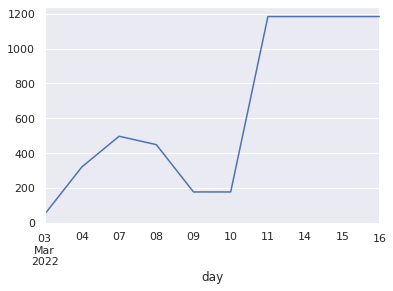

In [ ]:
productionDf.groupby(by='day').sum()['quantity'].plot()


<AxesSubplot:xlabel='day'>

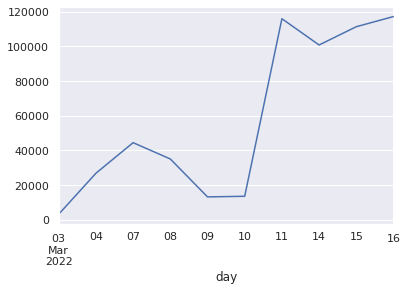

In [ ]:
productionDf.groupby(by='day').sum()['revenue_total'].plot()

In [ ]:
productionDf.groupby(by='day').sum()['revenue_total'].sum()

988240.0

### Loop over all periods

In [ ]:
def completeHorizonMultiplePeriodILP(periodBegin, periodEnd, articles, purchasing, bom, nPeriods):
    daysInPeriod = getBusDaysInPeriod(periodBegin, periodEnd)
    periods = np.array_split(daysInPeriod, nPeriods)
    productionDfs = []
    remainingInventory = None
    for i, period in enumerate(periods):
        print(f"Solving for period {i}: {period[0]} - {period[-1]}")
        periodPurchasing = purchasing[purchasing['date'].between(period[0], period[-1], inclusive='both')]
        inv = Inventory(periodPurchasing)
        print("len before addBeginInv", len(inv.purchasing))
        inv = inv.add(remainingInventory, date=period[0])
        print("after", len(inv.purchasing))
        #print(inv.purchasing)
        model, x = multiPeriodILP(daysInPeriod=period, articles = articlesBatch, inv = inv, bom = bomBatch)
        status = model.solve()
        productionDf = createProductionDf(x, period, articles)
        print(len(productionDf))
        print("Revenue: ", model.objective.value())
        remainingInventory = getRemainingComponents(productionDf, inv.purchasingForPeriod(period[0], period[-1]), bom)
        productionDfs.append(productionDf)
    completeProductionDf = pd.concat(productionDfs)
    return completeProductionDf

In [ ]:
periodBegin = pd.Timestamp('2022-02-16')
periodEnd = pd.Timestamp('2022-08-15') 
nPeriods = 7
completeProductionDf = completeHorizonMultiplePeriodILP(periodBegin, periodEnd, articles = articlesBatch, purchasing = purchasingProcessed, bom = bomBatch, nPeriods=nPeriods)

Solving for period 0: 2022-02-16 00:00:00 - 2022-03-04 00:00:00
len before addBeginInv 1329
after 1329
Multi period ILP for period 2022-02-16 00:00:00 to 2022-03-04 00:00:00
This entails 13 days: [Timestamp('2022-02-16 00:00:00', freq='B')
 Timestamp('2022-02-17 00:00:00', freq='B')
 Timestamp('2022-02-18 00:00:00', freq='B')
 Timestamp('2022-02-21 00:00:00', freq='B')
 Timestamp('2022-02-22 00:00:00', freq='B')
 Timestamp('2022-02-23 00:00:00', freq='B')
 Timestamp('2022-02-24 00:00:00', freq='B')
 Timestamp('2022-02-25 00:00:00', freq='B')
 Timestamp('2022-02-28 00:00:00', freq='B')
 Timestamp('2022-03-01 00:00:00', freq='B')
 Timestamp('2022-03-02 00:00:00', freq='B')
 Timestamp('2022-03-03 00:00:00', freq='B')
 Timestamp('2022-03-04 00:00:00', freq='B')]
13,139316
Revenue:  1906992.0
remaininginv component_number
0        2009.0
1        1998.0
2           0.0
3        4074.0
4        4554.0
         ...   
1389    15798.0
1390      691.0
1391     6586.0
1392        0.0
1393    131

KeyboardInterrupt: 

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
completeProductionDf.to_csv('completeProduction12dayinterval.csv')

In [ ]:
completeProductionDf

,day,day_nr,article_number,quantity_batch,quantity,article_revenue,revenue_total
5824,2022-02-16,1,437,1.0,16.0,19104,305664.0
3225,2022-02-17,2,11,1.0,16.0,16448,263168.0
366,2022-02-18,3,287,13.0,208.0,21440,4459520.0
1695,2022-02-23,6,124,1.0,16.0,16736,267776.0
5193,2022-02-24,7,98,18.0,288.0,20064,5778432.0
813,2022-02-25,8,66,1.0,16.0,18976,303616.0
5025,2022-02-25,8,79,3.0,48.0,24480,1175040.0
477,2022-03-01,10,174,1.0,16.0,14640,234240.0
2050,2022-03-01,10,404,2.0,32.0,19552,625664.0
6288,2022-03-01,10,430,1.0,16.0,26768,428288.0


In [ ]:
completeProductionDf['revenue_total'].sum()

314638080.0

In [ ]:
completeProductionDf['quantity'].sum() 

14480.0

In [ ]:
314.638.080.0
266.938.720.0

<AxesSubplot:xlabel='day'>

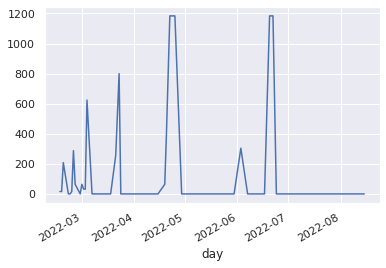

In [ ]:
completeProductionDf.groupby(by='day').sum().reindex(productionDays, fill_value=0)['quantity'].plot()

In [ ]:
completeProductionDfGrouped = completeProductionDf.groupby(by='article_number').sum()['quantity']
pd.merge(left=completeProductionDfGrouped, right=bom, left_on='article_number', right_on='article_number', how ='left')

,article_number,quantity_x,component_number,start_date,end_date,quantity_y
0,11,16.0,1377,20211207.0,29991231.0,2
1,11,16.0,110,20200108.0,29991231.0,1
2,11,16.0,1261,20200714.0,29991231.0,1
3,11,16.0,696,20200108.0,29991231.0,1
4,11,16.0,1216,20200108.0,29991231.0,36
...,...,...,...,...,...,...
1534,437,16.0,1236,20201127.0,29991231.0,1
1535,437,16.0,473,20220208.0,29991231.0,1
1536,437,16.0,724,20201021.0,29991231.0,1
1537,437,16.0,415,20201021.0,29991231.0,1


In [ ]:
#comparing to naive
comp_prod = pd.read_csv("1-year-prod.csv")
comp_rev = pd.read_csv("1-year-rev.csv")

In [ ]:
comp_rev['revenue'].sum()

266938720.0

In [ ]:
comp_prod['date'] = pd.to_datetime(comp_prod['date'])

<AxesSubplot:xlabel='date'>

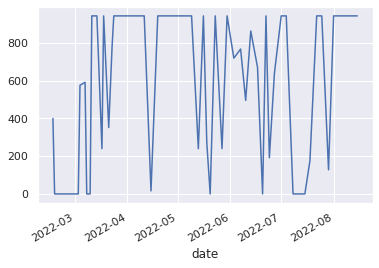

In [ ]:
comp_prod.groupby(by='date').sum().reindex(productionDays, fill_value=0)['quantity'].plot()

In [ ]:
comp_prod['quantity'].sum()

205440

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=503941b5-1736-4298-9362-1ed0707166ae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>